## 1. 📦 Imports et Configuration

In [1]:
# Imports standards
import pandas as pd
import numpy as np
import os
import re
import pickle
import warnings
from datetime import datetime
from collections import Counter

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# NLP - Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

print("✅ Tous les packages importés avec succès!")
print(f"📅 Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Tous les packages importés avec succès!
📅 Date d'exécution: 2025-12-14 14:02:21


## 2. 📁 Chargement des Données Brutes

In [8]:
# Définir le chemin du dataset
DATA_PATH = r'C:\Users\user\Downloads\Notre_Mlops\data\final_result1.xlsx'

try:
    df = pd.read_excel(DATA_PATH)
    print(f"✅ Dataset chargé avec succès!")
    print(f"📊 Dimensions: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
    print(f"💾 Utilisation mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
    print(f"❌ Erreur: Le fichier '{DATA_PATH}' n'a pas été trouvé!")
    raise

✅ Dataset chargé avec succès!
📊 Dimensions: 3,434 lignes × 2 colonnes
💾 Utilisation mémoire: 0.79 MB


## 3. 🔍 Exploration Initiale des Données (EDA)

In [9]:
# Afficher les premières lignes
print("📋 Aperçu du dataset:")
print("="*80)
df.head()

📋 Aperçu du dataset:


,comments,target
0,لا للانتخابات مع العصابات يا البلاد صحافة العار,0
1,قيس السعيد ذكرني بالراحل محمد بوضياف رحمه الله...,1
2,في رئيي نبيل القروي مخادع لن يصلح أبدا جزائري ...,1
3,قيس سعيد يبدو اصدق,1
4,اتمنى الا يفوز من تدعمه اسراءيل,1


In [10]:
# Informations sur les colonnes
print("\n📊 Informations sur les colonnes:")
print("="*80)
df.info()


📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434 entries, 0 to 3433
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  3434 non-null   object
 1   target    3434 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 53.8+ KB



🎯 Distribution de la variable cible (target):
target
0    1762
1    1672
Name: count, dtype: int64

Taux de classe 1 (soutien): 48.69%
Taux de classe 0 (opposition): 51.31%


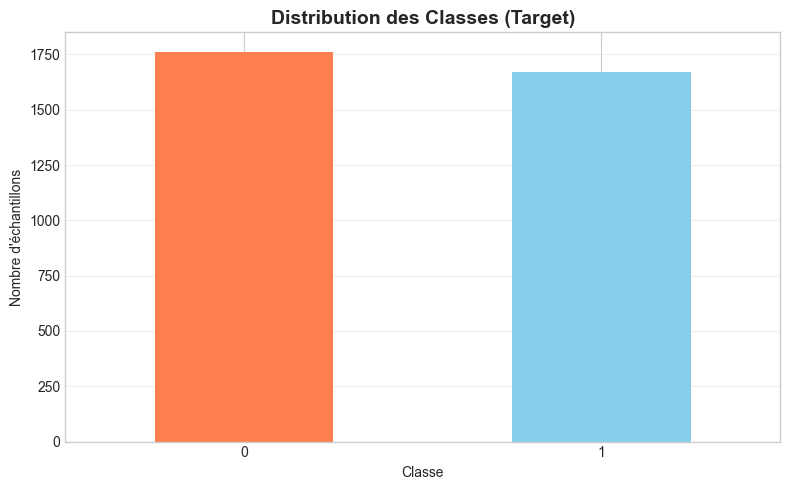

In [11]:
# Distribution de la variable cible
print("\n🎯 Distribution de la variable cible (target):")
print("="*80)
print(df['target'].value_counts())
print(f"\nTaux de classe 1 (soutien): {df['target'].mean()*100:.2f}%")
print(f"Taux de classe 0 (opposition): {(1-df['target'].mean())*100:.2f}%")

# Visualisation
plt.figure(figsize=(8, 5))
df['target'].value_counts().plot(kind='bar', color=['coral', 'skyblue'])
plt.title('Distribution des Classes (Target)', fontsize=14, fontweight='bold')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Statistiques descriptives sur les commentaires
df['comment_length'] = df['comments'].astype(str).apply(len)
df['word_count'] = df['comments'].astype(str).apply(lambda x: len(x.split()))

print("\n📝 Statistiques sur les commentaires:")
print("="*80)
print(df[['comment_length', 'word_count']].describe())

# Vérifier les valeurs manquantes
print("\n🔍 Valeurs manquantes:")
print("="*80)
print(df.isnull().sum())


📝 Statistiques sur les commentaires:
       comment_length   word_count
count     3434.000000  3434.000000
mean        83.974083    15.301398
std         89.855343    15.923216
min          6.000000     2.000000
25%         31.000000     6.000000
50%         56.000000    10.000000
75%        106.000000    19.000000
max       1348.000000   218.000000

🔍 Valeurs manquantes:
comments          0
target            0
comment_length    0
word_count        0
dtype: int64


In [13]:
# Exemples de commentaires par classe
print("\n📌 Exemples de commentaires par classe:")
print("="*80)
print("\n🔴 Classe 0 (Opposition):")
for i, comment in enumerate(df[df['target']==0]['comments'].head(3), 1):
    print(f"  {i}. {comment}")

print("\n🟢 Classe 1 (Soutien):")
for i, comment in enumerate(df[df['target']==1]['comments'].head(3), 1):
    print(f"  {i}. {comment}")


📌 Exemples de commentaires par classe:

🔴 Classe 0 (Opposition):
  1. لا للانتخابات مع العصابات يا البلاد صحافة العار
  2. هدا قيس ماعجبنيش يالطيف ربي يحفظ تونس الشقيقة اول مرة نشوف واحد ونخاف منو ياتونس ربي يحميك من ولاد لحرام
  3. كل حكام العرب  عبث  وطوغات   والا رحتا لاناء  مع هد ااقوم المجرم  الماذ الدمار الشامل القتل الاطفال وشيوم والبشر كافه ولا احد يتكلم عن الضلم  ويقولو الارهاب هم الارهاب الحقيقي

🟢 Classe 1 (Soutien):
  1. قيس السعيد ذكرني بالراحل محمد بوضياف رحمه الله. بالتوفيق لشعب التونسي في اختيارهم
  2. في رئيي نبيل القروي مخادع لن يصلح أبدا جزائري محب لتونس الشقيقة
  3. قيس سعيد يبدو اصدق


## 4. 🧹 Nettoyage et Normalisation du Texte Arabe

In [14]:
# Extraction des features et labels
X = list(df["comments"])
y = df["target"]

print(f"✅ Extraction réussie:")
print(f"   • Nombre de commentaires: {len(X):,}")
print(f"   • Nombre de labels: {len(y):,}")

✅ Extraction réussie:
   • Nombre de commentaires: 3,434
   • Nombre de labels: 3,434


In [15]:
# Fonction de nettoyage pour le texte arabe en dialecte tunisien
def clean_arabic_text(text):
    """
    Nettoie le texte arabe en:
    - Gardant uniquement les lettres arabes et espaces
    - Supprimant les mots d'une seule lettre
    - Normalisant les espaces multiples
    """
    # Garder uniquement les lettres arabes et espaces
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", str(text))
    # Supprimer les mots arabes d'une seule lettre
    text = re.sub(r"\s[\u0600-\u06FF]{1}\s", " ", text)
    # Réduire les espaces multiples
    text = re.sub(r"\s+", " ", text)
    # Supprimer les espaces en début/fin
    text = text.strip()
    return text

# Appliquer le nettoyage
print("🧹 Nettoyage du texte en cours...")
tidy_X = [clean_arabic_text(comment) for comment in X]
print("✅ Nettoyage terminé!")

# Afficher des exemples avant/après
print("\n📋 Exemples de nettoyage:")
print("="*80)
for i in range(3):
    print(f"\n  Avant: {X[i][:100]}...")
    print(f"  Après: {tidy_X[i][:100]}...")

🧹 Nettoyage du texte en cours...
✅ Nettoyage terminé!

📋 Exemples de nettoyage:

  Avant: لا للانتخابات مع العصابات يا البلاد صحافة العار...
  Après: لا للانتخابات مع العصابات يا البلاد صحافة العار...

  Avant: قيس السعيد ذكرني بالراحل محمد بوضياف رحمه الله. بالتوفيق لشعب التونسي في اختيارهم...
  Après: قيس السعيد ذكرني بالراحل محمد بوضياف رحمه الله بالتوفيق لشعب التونسي في اختيارهم...

  Avant: في رئيي نبيل القروي مخادع لن يصلح أبدا جزائري محب لتونس الشقيقة...
  Après: في رئيي نبيل القروي مخادع لن يصلح أبدا جزائري محب لتونس الشقيقة...


## 5. 📊 Analyse de Fréquence des Mots

In [16]:
# Analyse des mots les plus fréquents
print("📊 Analyse de fréquence des mots...")
count_vectorizer = CountVectorizer()
word_counts = count_vectorizer.fit_transform(tidy_X)
word_freq = dict(zip(count_vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1))
sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

print("\n🔝 Top 50 mots les plus fréquents:")
print("="*80)
for i, (word, freq) in enumerate(sorted_freq[:50], 1):
    print(f"{i:2d}. {word:20s} → {freq:6.0f} occurrences")

📊 Analyse de fréquence des mots...

🔝 Top 50 mots les plus fréquents:
 1. قيس                  →   1326 occurrences
 2. سعيد                 →   1230 occurrences
 3. في                   →   1071 occurrences
 4. من                   →   1004 occurrences
 5. تونس                 →    913 occurrences
 6. لا                   →    580 occurrences
 7. الشعب                →    563 occurrences
 8. على                  →    547 occurrences
 9. يا                   →    536 occurrences
10. الله                 →    384 occurrences
11. كل                   →    277 occurrences
12. ما                   →    273 occurrences
13. التونسي              →    261 occurrences
14. هذا                  →    246 occurrences
15. هو                   →    230 occurrences
16. الرئيس               →    221 occurrences
17. مع                   →    201 occurrences
18. ان                   →    193 occurrences
19. ولا                  →    185 occurrences
20. كان                  →    171 occurrences
21. رئيس  

## 6. 🎯 Vectorisation TF-IDF avec Stopwords Tunisiens

In [17]:
# Liste personnalisée de stopwords en dialecte tunisien
tunisian_stopwords = [
    'شنوة', 'علاش', 'كيفاش', 'برشة', 'ماشي', 'باهي', 'هاو', 'هكة', 'علش', 'ماعادش',
    'مازال', 'هوني', 'توا', 'تو', 'معادش', 'ماهوش', 'ماني', 'راك', 'عليها', 'فيها',
    'هاك', 'دونك', 'هاوكا', 'وينو', 'شنيا', 'شكون', 'آش', 'بالحق', 'خاطر', 'اللي',
    'اذاكم', 'اذوما', 'هوما', 'هي', 'هو', 'هذا', 'كل', 'يا', 'ك', 'ل', 'ب', 'في',
    'على', 'عن', 'الى', 'من', 'برشا', 'انتي', 'انا', 'هم', 'احنا', 'نتي', 'مانيش', 'مافماش'
]

print(f"📝 Stopwords tunisiens définis: {len(tunisian_stopwords)} mots")

📝 Stopwords tunisiens définis: 54 mots


In [18]:
# Création du vectorizer TF-IDF
print("\n🎯 Création du vectorizer TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=1000,
    max_df=0.8,
    min_df=7,
    stop_words=tunisian_stopwords
)

# Transformation des données
X_vectorized = vectorizer.fit_transform(tidy_X).toarray()

print("✅ Vectorisation TF-IDF terminée!")
print(f"   • Forme de la matrice: {X_vectorized.shape}")
print(f"   • Nombre de features: {X_vectorized.shape[1]}")
print(f"   • Taille mémoire: {X_vectorized.nbytes / 1024**2:.2f} MB")


🎯 Création du vectorizer TF-IDF...
✅ Vectorisation TF-IDF terminée!
   • Forme de la matrice: (3434, 942)
   • Nombre de features: 942
   • Taille mémoire: 24.68 MB


In [19]:
# Afficher les features (mots) extraits
feature_names = vectorizer.get_feature_names_out()
print(f"\n📋 Exemples de features extraites (premiers 30 mots):")
print("="*80)
print(feature_names[:30])


📋 Exemples de features extraites (premiers 30 mots):
['آخر' 'أجل' 'أحد' 'أحدا' 'أحزاب' 'أحسن' 'أخرى' 'أصبح' 'أصبحت' 'أكبر'
 'أكثر' 'ألا' 'ألف' 'أما' 'أمام' 'أموال' 'أن' 'أنا' 'أنت' 'أنتم' 'أنه'
 'أو' 'أي' 'أين' 'أيها' 'إذا' 'إلا' 'إلى' 'إلي' 'إن']


## 7. 🔀 Split Stratifié des Données

In [20]:
# Split initial: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_vectorized, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Split temp: 50% val, 50% test (15% chacun du total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("✅ Split des données terminé!")
print("="*80)
print(f"   📊 Train set:      {X_train.shape[0]:,} samples ({X_train.shape[0]/len(y)*100:.1f}%)")
print(f"   📊 Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(y)*100:.1f}%)")
print(f"   📊 Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(y)*100:.1f}%)")
print(f"\n   Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,} samples")

✅ Split des données terminé!
   📊 Train set:      2,403 samples (70.0%)
   📊 Validation set: 515 samples (15.0%)
   📊 Test set:       516 samples (15.0%)

   Total: 3,434 samples


In [21]:
# Vérifier la distribution stratifiée
print("\n🎯 Vérification de la distribution stratifiée:")
print("="*80)
print(f"   Train - Classe 1: {y_train.mean()*100:.2f}%")
print(f"   Val   - Classe 1: {y_val.mean()*100:.2f}%")
print(f"   Test  - Classe 1: {y_test.mean()*100:.2f}%")
print(f"   Total - Classe 1: {y.mean()*100:.2f}%")
print("\n✅ Distribution bien stratifiée!")


🎯 Vérification de la distribution stratifiée:
   Train - Classe 1: 48.69%
   Val   - Classe 1: 48.74%
   Test  - Classe 1: 48.64%
   Total - Classe 1: 48.69%

✅ Distribution bien stratifiée!


## 8. 💾 Sauvegarde des Artefacts Preprocessés

In [22]:
# Créer le dossier processors
PROCESSOR_DIR = '../processors'
os.makedirs(PROCESSOR_DIR, exist_ok=True)

print(f"📁 Dossier de sauvegarde: {PROCESSOR_DIR}")

📁 Dossier de sauvegarde: ../processors


In [23]:
# Sauvegarder les données preprocessées
print("\n💾 Sauvegarde des données preprocessées...")

preprocessed_data = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'feature_names': feature_names,
    'metadata': {
        'n_features': X_vectorized.shape[1],
        'n_samples_train': X_train.shape[0],
        'n_samples_val': X_val.shape[0],
        'n_samples_test': X_test.shape[0],
        'preprocessing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

with open(os.path.join(PROCESSOR_DIR, 'preprocessed_data.pkl'), 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("✅ Données preprocessées sauvegardées!")


💾 Sauvegarde des données preprocessées...
✅ Données preprocessées sauvegardées!


In [24]:
# Sauvegarder le vectorizer TF-IDF
print("\n💾 Sauvegarde du vectorizer TF-IDF...")
with open(os.path.join(PROCESSOR_DIR, 'tfidf_vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)

print("✅ Vectorizer sauvegardé!")


💾 Sauvegarde du vectorizer TF-IDF...
✅ Vectorizer sauvegardé!


In [25]:
# Sauvegarder les textes nettoyés pour référence future
print("\n💾 Sauvegarde des textes nettoyés...")
cleaned_texts = {
    'original': X,
    'cleaned': tidy_X,
    'labels': y.values
}

with open(os.path.join(PROCESSOR_DIR, 'cleaned_texts.pkl'), 'wb') as f:
    pickle.dump(cleaned_texts, f)

print("✅ Textes nettoyés sauvegardés!")


💾 Sauvegarde des textes nettoyés...
✅ Textes nettoyés sauvegardés!


In [26]:
# Résumé final
print("\n" + "="*80)
print("📋 RÉSUMÉ DU PREPROCESSING")
print("="*80)
print(f"\n✅ Artefacts sauvegardés dans: {PROCESSOR_DIR}")
print("\n📦 Fichiers créés:")
print("   1. preprocessed_data.pkl    → Données train/val/test vectorisées")
print("   2. tfidf_vectorizer.pkl     → Vectorizer TF-IDF ajusté")
print("   3. cleaned_texts.pkl        → Textes originaux et nettoyés")
print("\n📊 Statistiques:")
print(f"   • Nombre total d'échantillons: {len(y):,}")
print(f"   • Nombre de features TF-IDF: {X_vectorized.shape[1]}")
print(f"   • Train: {X_train.shape[0]:,} | Val: {X_val.shape[0]:,} | Test: {X_test.shape[0]:,}")
print("\n🎯 Prêt pour la modélisation!")
print("="*80)


📋 RÉSUMÉ DU PREPROCESSING

✅ Artefacts sauvegardés dans: ../processors

📦 Fichiers créés:
   1. preprocessed_data.pkl    → Données train/val/test vectorisées
   2. tfidf_vectorizer.pkl     → Vectorizer TF-IDF ajusté
   3. cleaned_texts.pkl        → Textes originaux et nettoyés

📊 Statistiques:
   • Nombre total d'échantillons: 3,434
   • Nombre de features TF-IDF: 942
   • Train: 2,403 | Val: 515 | Test: 516

🎯 Prêt pour la modélisation!
